# The Ablowitz–Ladik system

In this notebook we will perform some numerical simulations of the Ablowitz–Ladik system, as introduced in [[1]](https://pubs.aip.org/aip/jmp/article-abstract/16/3/598/447434/Nonlinear-differential-difference-equations?redirectedFrom=fulltext) and studied in [[2]](https://iopscience.iop.org/article/10.1088/1361-6544/acd978).

The system models the time-evolution of a field $\alpha \colon \symbb{Z} \times [0, \infty) \to \symbb{C}$, with the equation
$$
    i \partial_t \alpha_n = - \left(\alpha_{n - 1} - 2 \alpha_n + \alpha_{n + 1}\right) + \alpha_n \beta_n \left(\alpha_{n - 1} + \alpha_{n + 1}\right)
$$
where $\beta_n \coloneqq \overline{\alpha_n}$ for the _defocusing case_ and $\beta_n \coloneqq - \overline{\alpha_n}$ in the _focusing case_.

This equation was introduced to model the one-dimensional cubic Schrödinger equation,
$$
    i \partial_ t \psi = - \Delta \psi \pm 2 \lvert \psi \rvert^2 \psi
$$
where $\psi \colon \symbb{R} \times [0, \infty) \to \symbb{C}$ is a complex wavefunction.

In [1]:
using ModelingToolkit
using DomainSets
using MethodOfLines
using OrdinaryDiffEq
using Plots

## Bound particle

In [2]:
@parameters t, x
# TODO: directly use a complex-valued dependent variable
# once Symbolics.jl gets fixed
@variables ψ_real(..) ψ_imag(..)

ψ(t, x) = ψ_real(t, x) + 1im * ψ_imag(t, x)

Dt = Differential(t)
Dxx = Differential(x)^2

Δ(u) = Dxx(u)

# V(t, x) = x^2
V(t, x) = 2 * abs(ψ(t, x))^2

equations = [
    # 1im * Dt(ψ(t, x)) ~ -Δ(ψ(t, x)) + V(t, x) * ψ(t, x),
    Dt(ψ_real(t, x)) ~ -Δ(ψ_imag(t, x)) + V(t, x) * ψ_imag(t, x),
    - Dt(ψ_imag(t, x)) ~ -Δ(ψ_real(t, x)) + V(t, x) * ψ_real(t, x),
]

x_min = 0.0
x_max = 1.0
t_max = 3.0

ψ₀ = x -> sin(2 * pi * x)

boundary_conditions = [
    ψ_real(0, x) ~ ψ₀(x),
    ψ_imag(0, x) ~ 0,
    ψ_real(t, x_min) ~ 0,
    ψ_imag(t, x_min) ~ 0,
    ψ_real(t, x_max) ~ 0,
    ψ_imag(t, x_max) ~ 0
]

domains = [
    t ∈ Interval(0, t_max),
    x ∈ Interval(x_min, x_max)
]

@named pde_system = PDESystem(
    equations, boundary_conditions, domains, 
    [t, x], [ψ_real(t, x), ψ_imag(t, x)]
)

PDESystem
Equations: Equation[Differential(t)(ψ_real(t, x)) ~ -Differential(x)(Differential(x)(ψ_imag(t, x))) + 2(hypot(ψ_real(t, x), ψ_imag(t, x))^2)*ψ_imag(t, x), -Differential(t)(ψ_imag(t, x)) ~ -Differential(x)(Differential(x)(ψ_real(t, x))) + 2(hypot(ψ_real(t, x), ψ_imag(t, x))^2)*ψ_real(t, x)]
Boundary Conditions: Equation[ψ_real(0, x) ~ sin(6.283185307179586x), ψ_imag(0, x) ~ 0, ψ_real(t, 0.0) ~ 0, ψ_imag(t, 0.0) ~ 0, ψ_real(t, 1.0) ~ 0, ψ_imag(t, 1.0) ~ 0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 3.0), Symbolics.VarDomainPairing(x, 0.0 .. 1.0)]
Dependent Variables: Num[ψ_real(t, x), ψ_imag(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

Discretize the problem using finite differences:

In [3]:
discretization = MOLFiniteDifference([x => 32], t);

In [4]:
problem = discretize(pde_system, discretization)
;

We solve the resulting ODEs, using the TRBDF2 algorithm (a solver specialized for 2-nd order problems arising out of mechanics):

In [5]:
solution = solve(problem, TRBDF2(), saveat = 0.01);
solution.retcode

ReturnCode.Success = 1

[ Info: Saved animation to /Users/gabrielmajeri/Projects/Doctorat/PhysicsSimulations/notebooks/schroedinger.gif


Plots.AnimatedGif("/Users/gabrielmajeri/Projects/Doctorat/PhysicsSimulations/notebooks/schroedinger.gif")
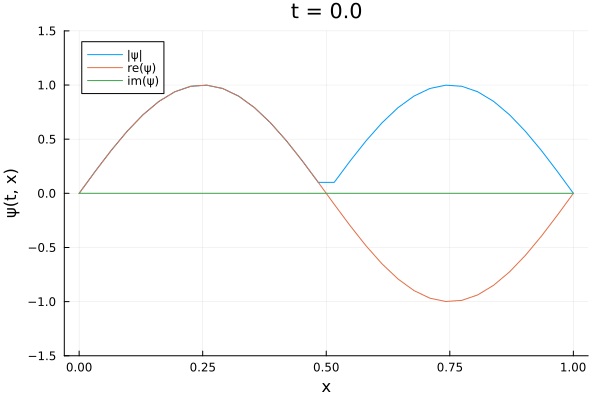

In [6]:
discretized_x = solution[x]
discretized_t = solution[t]
discretized_ψ = solution[ψ_real(t, x)] + 1im * solution[ψ_imag(t, x)]

animation = @animate for i in eachindex(discretized_t)
    u = discretized_ψ[i, :]
    plot(discretized_x, [abs.(u), real.(u), imag.(u)],
        ylim = (-1.5, 1.5),
        title = "t = $(discretized_t[i])",
        xlabel = "x", ylabel = "ψ(t, x)",
        label = ["|ψ|" "re(ψ)" "im(ψ)"], legend = :topleft)
end
gif(animation, "schroedinger.gif", fps = 30)

## Freely-moving particle

In [26]:
# V(t, x) = x^2
V(t, x) = 2 * abs(ψ(t, x))^2

equations = [
    # 1im * Dt(ψ(t, x)) ~ -Δ(ψ(t, x)) + V(t, x) * ψ(t, x),
    Dt(ψ_real(t, x)) ~ -Δ(ψ_imag(t, x)) + V(t, x) * ψ_imag(t, x),
    - Dt(ψ_imag(t, x)) ~ -Δ(ψ_real(t, x)) + V(t, x) * ψ_real(t, x),
]

x_min = -2.0
x_max = 8.0
t_max = 2.0

σ = 0.5
ψ₀ = x -> 1/(σ * sqrt(2pi)) * exp((-x^2)/(2*σ^2))

boundary_conditions = [
    ψ_real(0, x) ~ ψ₀(x),
    ψ_imag(0, x) ~ 0,
    ψ_real(t, x_min) ~ 0,
    ψ_imag(t, x_min) ~ 0,
    ψ_real(t, x_max) ~ 0,
    ψ_imag(t, x_max) ~ 0,
]

domains = [
    t ∈ Interval(0, t_max),
    x ∈ Interval(x_min, x_max)
]

@named pde_system = PDESystem(
    equations, boundary_conditions, domains, 
    [t, x], [ψ_real(t, x), ψ_imag(t, x)]
)

PDESystem
Equations: Equation[Differential(t)(ψ_real(t, x)) ~ -Differential(x)(Differential(x)(ψ_imag(t, x))) + 2(hypot(ψ_real(t, x), ψ_imag(t, x))^2)*ψ_imag(t, x), -Differential(t)(ψ_imag(t, x)) ~ -Differential(x)(Differential(x)(ψ_real(t, x))) + 2(hypot(ψ_real(t, x), ψ_imag(t, x))^2)*ψ_real(t, x)]
Boundary Conditions: Equation[ψ_real(0, x) ~ 0.7978845608028654exp(-2.0(x^2)), ψ_imag(0, x) ~ 0, ψ_real(t, -2.0) ~ 0, ψ_imag(t, -2.0) ~ 0, ψ_real(t, 8.0) ~ 0, ψ_imag(t, 8.0) ~ 0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 2.0), Symbolics.VarDomainPairing(x, -2.0 .. 8.0)]
Dependent Variables: Num[ψ_real(t, x), ψ_imag(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [27]:
discretization = MOLFiniteDifference([x => 64], t);
problem = discretize(pde_system, discretization);
solution = solve(problem, TRBDF2(), saveat = 0.01);
solution.retcode

ReturnCode.Success = 1

[ Info: Saved animation to /Users/gabrielmajeri/Projects/Doctorat/PhysicsSimulations/notebooks/schroedinger.gif


Plots.AnimatedGif("/Users/gabrielmajeri/Projects/Doctorat/PhysicsSimulations/notebooks/schroedinger.gif")
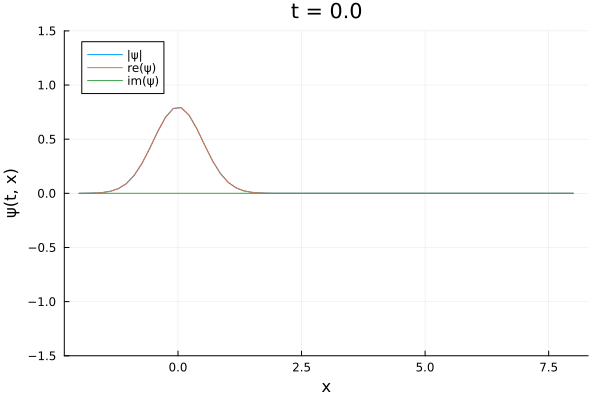

In [28]:
discretized_x = solution[x]
discretized_t = solution[t]
discretized_ψ = solution[ψ_real(t, x)] + 1im * solution[ψ_imag(t, x)]

animation = @animate for i in eachindex(discretized_t)
    u = discretized_ψ[i, :]
    plot(discretized_x, [abs.(u), real.(u), imag.(u)],
        ylim = (-1.5, 1.5),
        title = "t = $(discretized_t[i])",
        xlabel = "x", ylabel = "ψ(t, x)",
        label = ["|ψ|" "re(ψ)" "im(ψ)"], legend = :topleft)
end
gif(animation, "schroedinger.gif", fps = 30)